## from notebook

In [113]:
# duplicate libiomp5.dylib error fix
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# imports
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import init
from torch.nn import functional as F
import math

import time
import neurogym as ngym

import logging
from sklearn.decomposition import PCA

# plotting - science style
import matplotlib.pyplot as plt # type: ignore
import scienceplots # type: ignore
plt.style.use('science')
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
# parameters for the science style -- too many 
plt.style.use(['science','no-latex'])
plt.rcParams.update({
    "font.size": 16,
    "axes.labelsize": 16,
    "legend.fontsize": 16,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "axes.linewidth": 1,
    "axes.edgecolor": "black",
    "legend.fancybox": True,
    "legend.frameon": True,
    "legend.edgecolor": "black",
    "axes.facecolor": "white",
    "axes.grid": True,
    "grid.color": "#b7b7b7",
    "grid.linestyle": "-",
    "grid.linewidth": 0.5,
})



In [114]:
# SELECT TASK
task_number = 1

if task_number == 1:
    task_name = 'PerceptualDecisionMaking-v0' #task 1 - stimulus
else:
    task_name = 'PerceptualDecisionMakingDelayResponse-v0' # task 2 - stimulus and delay

# create environment
kwargs = {'dt': 20, 'timing': {'stimulus': 1000}}

# Make supervised dataset
seq_len = 100
batch_size = 16
#Create the dataset (Hover over ngym.Dataset to see input arguments)
dataset = ngym.Dataset(task_name, env_kwargs=kwargs, seq_len=seq_len, batch_size=batch_size)
env = dataset.env

# Generate one batch of data when called
inputs, target = dataset()
inputs = torch.from_numpy(inputs).type(torch.float)

input_size = env.observation_space.shape[0]
output_size = env.action_space.n



In [115]:
# helper function to train the model edited to return the training steps and losses, and to allow for change in number of steps

def train_model(net, dataset, criterion, model = None, return_train = False, steps_num = 2000, sub_steps = 100):
    """Simple helper function to train the model.

    Args:
        net: a pytorch nn.Module module
        dataset: a dataset object that when called produce a (input, target output) pair
        criterion: a pytorch loss function
        model: a model object that is used in the loss function

    Returns:
        net: network object after training
    """
    # Use Adam optimizer
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    
    # Initialize the lists to store the loss and steps
    steps = []
    losses = []

    running_loss = 0
    running_acc = 0
    start_time = time.time()
    # Loop over training batches
    print('Training network...')
    for i in range(steps_num):
        # Generate input and target, convert to pytorch tensor
        inputs, labels = dataset()
        inputs = torch.from_numpy(inputs).type(torch.float)
        labels = torch.from_numpy(labels.flatten()).type(torch.long)

        # boiler plate pytorch training:
        optimizer.zero_grad()   # zero the gradient buffers
        output, _ = net(inputs)
        # Reshape to (SeqLen x Batch, OutputSize)
        output = output.view(-1, output_size)
        if model == None:
            loss = criterion(output, labels)
        else:
            loss = criterion(output, labels, model)
        loss.backward()
        optimizer.step()    # Does the update

        # Compute the running loss every 100 steps
        running_loss += loss.item()
        if i % sub_steps == sub_steps-1:
            running_loss /= sub_steps
            print('Step {}, Loss {:0.4f}, Time {:0.1f}s'.format(
                i+1, running_loss, time.time() - start_time))
            

            # Append the loss and step
            steps.append(i+1)
            losses.append(running_loss)

            running_loss = 0

    # Return the trained network
    if return_train:
        return net, steps, losses
    else:
        return net

In [116]:
# define penalties
def sparsity_penalty(model, beta_sparsity=0.5):
    """Compute sparsity penalty based on the model's weights."""
    return beta_sparsity * torch.sum(torch.abs(model.fc.weight))

def firing_rate_penalty(output, beta_firing_rate=0.5): # output instead of model because computationally easier
    """Compute penalty for high firing rates based on the model's output."""
    return beta_firing_rate * torch.sum(torch.square(output))

# define loss function
def loss_brain_penalties(output, target, model, 
                                beta_sparsity=0.05, beta_firing_rate=0.5):
    """
    Compute the total loss with added penalties for sparsity, firing rate, and long-distance connections.
    """
    # Base task-specific loss - same as before
    loss = nn.CrossEntropyLoss()(output, target)

    # Add penalties
    total_loss = loss
    total_loss += sparsity_penalty(model, beta_sparsity)
    total_loss += firing_rate_penalty(output, beta_firing_rate)
    
    return total_loss

# CircuitNet Simple

In [117]:
class CMUSimple(nn.Module):
    # Simple CMU with 2 linear layers
    def __init__(self, input_size=3, hidden_size=64, output_size=128):
        super(CMUSimple, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))  
        x = self.relu(self.fc2(x)) 
        return x
    
class SimpleCircuitNet(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, output_size=3, num_cmus=5):
        super(SimpleCircuitNet, self).__init__()
        self.cmus = nn.ModuleList([CMUSimple(input_size, hidden_size, 128) for _ in range(num_cmus)])
        self.fc = nn.Linear(128, output_size) 

    def forward(self, x):
        hidden_activations = []

        # Pass input through all CMUs
        for cmu in self.cmus:
            hidden_activations.append(cmu(x)) 
        
        x = hidden_activations[-1]  
        x = self.fc(x)
        
        return x, hidden_activations


### no penalty

In [118]:
# parameters
num_cmus = 5  # number of CMUs
hidden_size = 128  # hidden size in each CMU

# initialise
net = SimpleCircuitNet(input_size=input_size, hidden_size=hidden_size, output_size=output_size, num_cmus=num_cmus)
print(net)

# Loss function
criterion = nn.CrossEntropyLoss()

# Train the model using the helper function
net_SCN_np, SCN_np_s, SCN_np_l = train_model(net, dataset, criterion, return_train=True, steps_num=500, sub_steps=10)

SimpleCircuitNet(
  (cmus): ModuleList(
    (0-4): 5 x CMUSimple(
      (fc1): Linear(in_features=3, out_features=128, bias=True)
      (fc2): Linear(in_features=128, out_features=128, bias=True)
      (relu): ReLU()
    )
  )
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
Training network...
Step 10, Loss 0.3481, Time 0.1s
Step 20, Loss 0.0828, Time 0.2s
Step 30, Loss 0.0589, Time 0.3s
Step 40, Loss 0.0599, Time 0.3s
Step 50, Loss 0.0603, Time 0.4s
Step 60, Loss 0.0553, Time 0.5s
Step 70, Loss 0.0598, Time 0.5s
Step 80, Loss 0.0606, Time 0.6s
Step 90, Loss 0.0556, Time 0.7s
Step 100, Loss 0.0592, Time 0.7s
Step 110, Loss 0.0592, Time 0.8s
Step 120, Loss 0.0558, Time 0.9s
Step 130, Loss 0.0587, Time 0.9s
Step 140, Loss 0.0604, Time 1.0s
Step 150, Loss 0.0556, Time 1.1s
Step 160, Loss 0.0587, Time 1.1s
Step 170, Loss 0.0598, Time 1.2s
Step 180, Loss 0.0561, Time 1.3s
Step 190, Loss 0.0590, Time 1.4s
Step 200, Loss 0.0593, Time 1.4s
Step 210, Loss 0.0564, Time 1.5s
Step 220

### sparsity

In [119]:
# Initialize the CircuityNet model
net = SimpleCircuitNet(input_size=input_size, hidden_size=hidden_size, output_size=output_size, num_cmus=num_cmus)

# Train the model using the helper function
net_SCN_sp, SCN_sp_s, SCN_sp_l = train_model(
    net, 
    dataset, 
    lambda output, target, model: loss_brain_penalties(output, target, model, beta_sparsity=0.5, beta_firing_rate=0),
    model=net,  # pass for penalty calc
    return_train=True,
    steps_num=500, sub_steps=10
)

Training network...
Step 10, Loss 4.2822, Time 0.1s
Step 20, Loss 1.6799, Time 0.1s
Step 30, Loss 0.9711, Time 0.2s
Step 40, Loss 0.6711, Time 0.3s
Step 50, Loss 0.5323, Time 0.4s
Step 60, Loss 0.4721, Time 0.4s
Step 70, Loss 0.4403, Time 0.5s
Step 80, Loss 0.4261, Time 0.6s
Step 90, Loss 0.4060, Time 0.7s
Step 100, Loss 0.3994, Time 0.8s
Step 110, Loss 0.3983, Time 0.8s
Step 120, Loss 0.4074, Time 0.9s
Step 130, Loss 0.3856, Time 1.0s
Step 140, Loss 0.3908, Time 1.0s
Step 150, Loss 0.3865, Time 1.1s
Step 160, Loss 0.3820, Time 1.2s
Step 170, Loss 0.3805, Time 1.2s
Step 180, Loss 0.3702, Time 1.3s
Step 190, Loss 0.3695, Time 1.4s
Step 200, Loss 0.3731, Time 1.5s
Step 210, Loss 0.3760, Time 1.6s
Step 220, Loss 0.4105, Time 1.7s
Step 230, Loss 0.3761, Time 1.7s
Step 240, Loss 0.3714, Time 1.8s
Step 250, Loss 0.3558, Time 1.9s
Step 260, Loss 0.3603, Time 1.9s
Step 270, Loss 0.3470, Time 2.0s
Step 280, Loss 0.3597, Time 2.1s
Step 290, Loss 0.3688, Time 2.1s
Step 300, Loss 0.3530, Time 2.2s

### low firing rates

In [120]:
# Initialize the CircuityNet model
net = SimpleCircuitNet(input_size=input_size, hidden_size=hidden_size, output_size=output_size, num_cmus=num_cmus)

# Train the model using the helper function
net_SCN_lfr, SCN_lfr_s, SCN_lfr_l = train_model(
    net, 
    dataset, 
    lambda output, target, model: loss_brain_penalties(output, target, model, beta_sparsity=0, beta_firing_rate=0.5),
    model=net,  # pass for penalty calc
    return_train=True,
    steps_num=500, sub_steps=10
)

Training network...
Step 10, Loss 101.2894, Time 0.1s
Step 20, Loss 2.7005, Time 0.2s
Step 30, Loss 1.2986, Time 0.2s
Step 40, Loss 1.1772, Time 0.3s
Step 50, Loss 1.1305, Time 0.4s
Step 60, Loss 1.1146, Time 0.4s
Step 70, Loss 1.1055, Time 0.5s
Step 80, Loss 1.1022, Time 0.6s
Step 90, Loss 1.1007, Time 0.7s
Step 100, Loss 1.1001, Time 0.8s
Step 110, Loss 1.0997, Time 0.8s
Step 120, Loss 1.0995, Time 0.9s
Step 130, Loss 1.0993, Time 1.0s
Step 140, Loss 1.0992, Time 1.1s
Step 150, Loss 1.1111, Time 1.1s
Step 160, Loss 1.1017, Time 1.2s
Step 170, Loss 1.0998, Time 1.3s
Step 180, Loss 1.0993, Time 1.3s
Step 190, Loss 1.0990, Time 1.4s
Step 200, Loss 1.0988, Time 1.5s
Step 210, Loss 1.0987, Time 1.6s
Step 220, Loss 1.0987, Time 1.7s
Step 230, Loss 1.0987, Time 1.7s
Step 240, Loss 1.0987, Time 1.8s
Step 250, Loss 1.0987, Time 1.9s
Step 260, Loss 1.0987, Time 2.0s
Step 270, Loss 1.0987, Time 2.0s
Step 280, Loss 1.0987, Time 2.1s
Step 290, Loss 1.0986, Time 2.2s
Step 300, Loss 1.0986, Time 2.

### plot

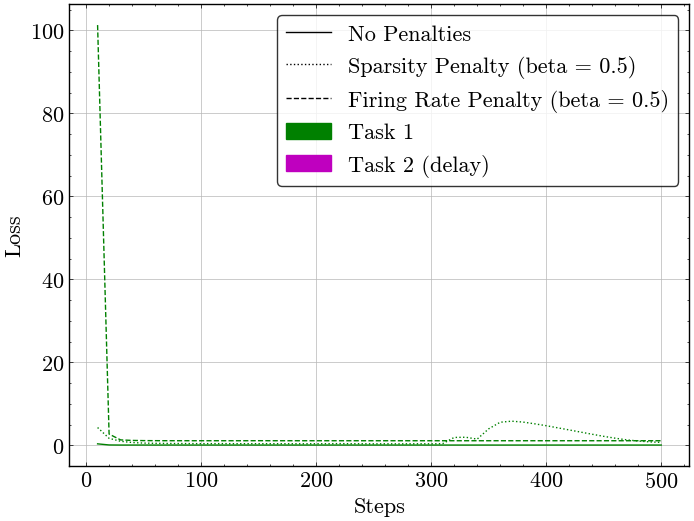

In [121]:
# create fig
plt.figure(figsize=(8, 6))


# define lines
line_styles = {
    'No Penalties': '-',  
    'Sparsity Penalty': ':',  
    'Firing Rate Penalty': '--',  
}



# leaky RNN (m1)
plt.plot(SCN_np_s, SCN_np_l, label='Simplified Circuit Net (No Penalties)', color='g', linestyle=line_styles['No Penalties'])
plt.plot(SCN_sp_s, SCN_sp_l, label='Simplified Circuit Net (Sparsity Penalty)', color='g', linestyle=line_styles['Sparsity Penalty'])
plt.plot(SCN_lfr_s, SCN_lfr_l, label='Simplified Circuit Net (Firing Rate Penalty)', color='g', linestyle=line_styles['Firing Rate Penalty'])



# custom legend
legend_elements = [
    mlines.Line2D([], [], color='k', linestyle=line_styles['No Penalties'], label='No Penalties'),
    mlines.Line2D([], [], color='k', linestyle=line_styles['Sparsity Penalty'], label='Sparsity Penalty (beta = 0.5)'),
    mlines.Line2D([], [], color='k', linestyle=line_styles['Firing Rate Penalty'], label='Firing Rate Penalty (beta = 0.5)'),
    mpatches.Patch(color='g', label='Task 1'),
    mpatches.Patch(color='m', label='Task 2 (delay)')
]

plt.xlabel('Steps')
plt.ylabel('Loss')

# add legend
plt.legend(handles=legend_elements)

# Show plot
plt.show()

In [ ]:
def plot_network_connectivity(net, env, task_number, num_trial=500):
    """
    Function to plot network connectivity from a trained model by averaging
    the activations across all CMUSimple modules.

    Args:
    - net (torch.nn.Module): The trained neural network model.
    - env (Environment): The environment used for training and testing.
    - task_number (int): The task number used for training and testing.
    - num_trial (int): The number of trials to run for performance and activity recording.
    """
    # Reset the environment
    env.reset(no_step=True)
    env.timing.update({'fixation': ('constant', 500),
                       'stimulus': ('constant', 500)})

    # Initialize variables to track performance, activity, and trial information
    activity_dict = {}
    trial_infos = {}

    # adapt for task 1 and task 2
    if task_number == 1:
        stim_activity = [[], []]
    else:
        stim_activity = [[], [], []]

    # Run trials 
    for i in range(num_trial):
        env.new_trial()
        ob, gt = env.ob, env.gt
        inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
        action_pred, rnn_activity = net(inputs)  # Get network prediction and activations

        # Compute performance
        action_pred = action_pred.detach().numpy()
        choice = np.argmax(action_pred[-1, 0, :])
        correct = choice == gt[-1]

        # Log trial info
        trial_info = env.trial
        trial_info.update({'correct': correct, 'choice': choice})
        trial_infos[i] = trial_info

        # Collect activations from all CMUSimple modules and average them
        all_activations = []
        for cmu in net.cmus:
            all_activations.append(cmu(inputs))  # Collect activations from each module
        
        # Average the activations across all CMUSimple modules
        avg_activation = torch.mean(torch.stack(all_activations), dim=0).detach().numpy()
        activity_dict[i] = avg_activation

        # Assume stimulus is within a defined range, based on the environment's indices
        avg_activation = avg_activation[env.start_ind['stimulus']: env.end_ind['stimulus']]
        stim_activity[env.trial['ground_truth']].append(avg_activation)

    # Compute stimulus selectivity for sorting neurons
    mean_activity = []
    std_activity = []

    for ground_truth in range(len(stim_activity)): # For each stimulus
        if stim_activity[ground_truth]:  # Ensure non-empty entries
            activity = np.concatenate(stim_activity[ground_truth], axis=0)
            mean_activity.append(np.mean(activity, axis=0))
            std_activity.append(np.std(activity, axis=0))
        else:
            mean_activity.append(np.zeros(net.cmus[0].fc1.out_features)) 
            std_activity.append(np.ones(net.cmus[0].fc1.out_features))

    # Compute d' (stimulus selectivity)
    selectivity = (mean_activity[0] - mean_activity[1])
    selectivity /= np.sqrt((std_activity[0]**2 + std_activity[1]**2 + 1e-7) / 2)

    # NEW (use fc2 as 'hiddem layer')
    fc2_weights = [cmu.fc2.weight.detach().numpy() for cmu in net.cmus] # Get the average weights of fc2 from all CMUSimple modules
    avg_fc2_weights = np.mean(fc2_weights, axis=0) # Compute the average of fc2 weights across all CMU modules
    wlim = np.max(np.abs(avg_fc2_weights))  # Set the limits for visualization

    # plot network connectivity
    plt.figure(figsize=(8, 6))
    plt.imshow(avg_fc2_weights, cmap='bwr_r', vmin=-wlim, vmax=wlim)
    plt.colorbar(label='Weight Value')
    plt.xlabel('From neurons')
    plt.ylabel('To neurons')
    plt.show()


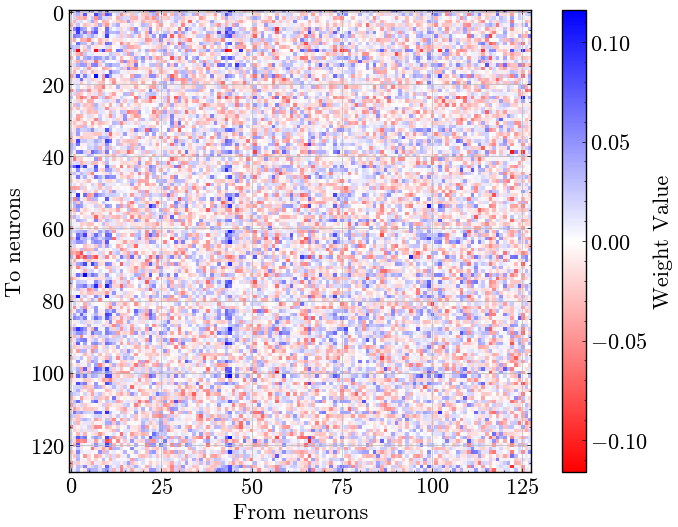

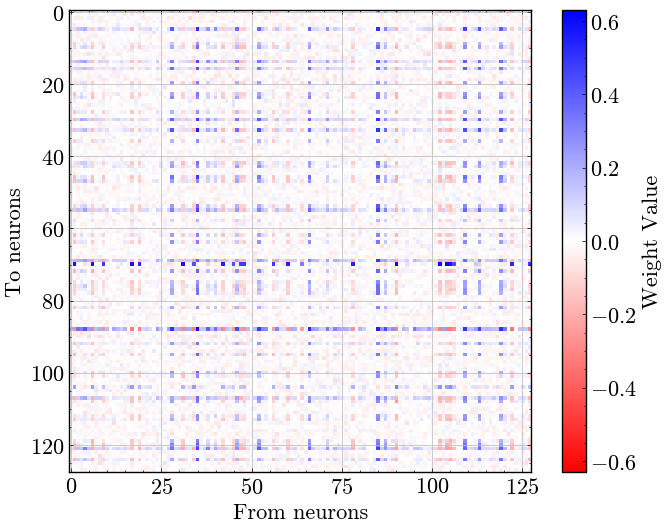

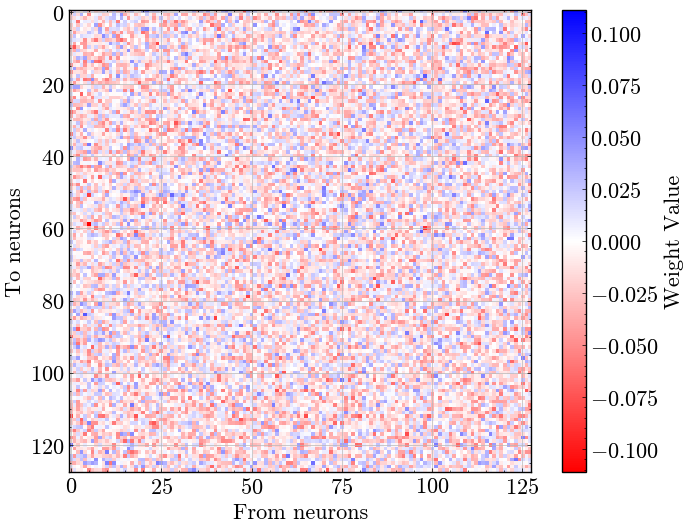

In [123]:
# plot network connectivity
plot_network_connectivity(net_SCN_np, env, task_number)
plot_network_connectivity(net_SCN_sp, env, task_number)
plot_network_connectivity(net_SCN_lfr, env, task_number)

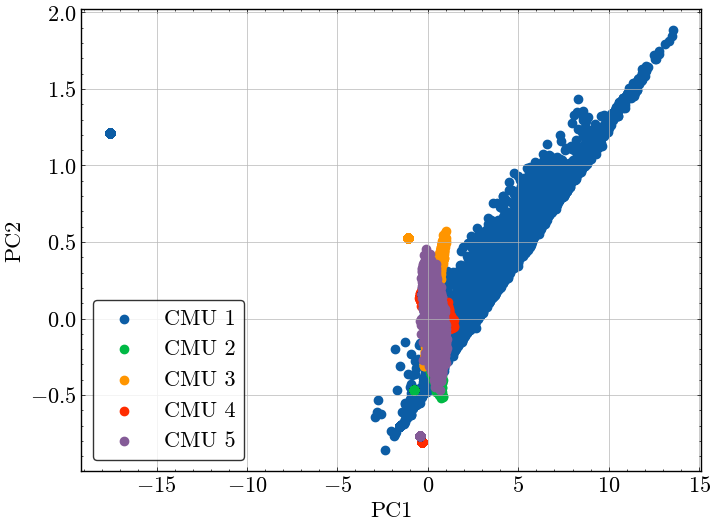

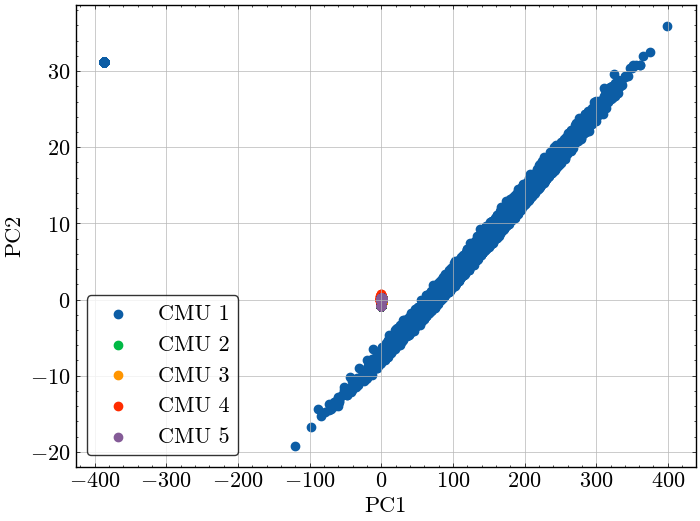

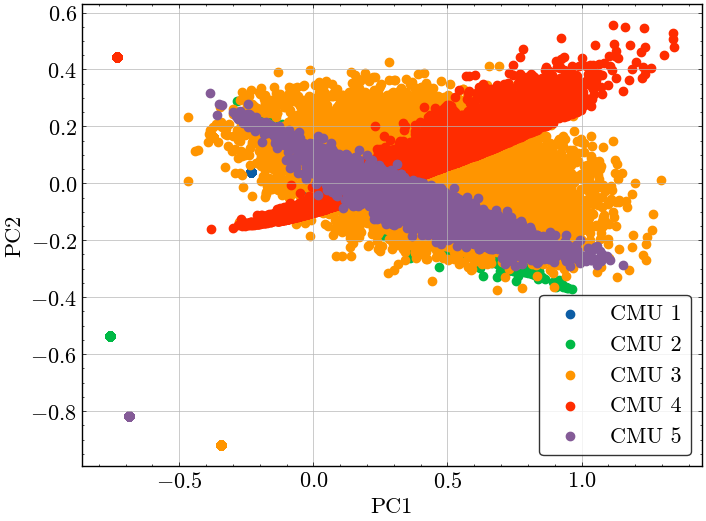

In [135]:
def analyze_hidden_unit_activity_PCA(net, env, num_trial=500):
    """
    Analyze the hidden unit activity of a trained RNN model (or a model with multiple CMUs)
    over multiple trials using PCA.
    
    Args:
    - net (torch.nn.Module): The trained neural network model.
    - env (Environment): The environment used for training and testing.
    - num_trial (int): The number of trials to run for activity recording.
    
    Returns:
    - reduced_activations (np.ndarray): PCA-reduced data.
    """
    # Reset the environment
    env.reset(no_step=True)
    env.timing.update({'fixation': ('constant', 500), 
                       'stimulus': ('constant', 500)})

    # Initialize a dictionary to store hidden unit activity for each trial
    activation_data = {}

    # Run trials and collect activations  - similar to what we did in lab 4
    for i in range(num_trial):
        env.new_trial()
        ob, gt = env.ob, env.gt
        inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)

        # Get model output and hidden unit activity
        action_pred, hidden_activations = net(inputs)
        
        # NEW: Collect activations from all CMUs (stored in hidden_activations)
        for j, activation in enumerate(hidden_activations):
            rnn_activity = activation[:, 0, :].detach().numpy() 
            if i == 0:  
                activation_data[j] = []
            activation_data[j].append(rnn_activity)

    # prep per CMU activations
    all_activations = []
    for activations in activation_data.values():
        all_activations.append(np.concatenate(activations, axis=0))

    # perform per CMU PCA
    pca = PCA(n_components=2)  # 2D PCA
    reduced_activations = []
    for cmu_activations in all_activations:
        reduced_activations.append(pca.fit_transform(cmu_activations))
    
    return reduced_activations


# Call the function for each network and collect PCA results
pca_m1 = analyze_hidden_unit_activity_PCA(net_SCN_np, env)

# Plot the PCA results
plt.figure(figsize=(8, 6))

# invert order of cmus
for i, reduced_activations in enumerate(pca_m1[::-1]):
    plt.scatter(reduced_activations[:, 0], reduced_activations[:, 1], label=f'CMU {i+1}')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

# Call the function for each network and collect PCA results
pca_m1 = analyze_hidden_unit_activity_PCA(net_SCN_sp, env)

# Plot the PCA results
plt.figure(figsize=(8, 6))

# invert order of cmus
for i, reduced_activations in enumerate(pca_m1[::-1]):
    plt.scatter(reduced_activations[:, 0], reduced_activations[:, 1], label=f'CMU {i+1}')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

# Call the function for each network and collect PCA results
pca_m1 = analyze_hidden_unit_activity_PCA(net_SCN_lfr, env)

# Plot the PCA results
plt.figure(figsize=(8, 6))

# invert order of cmus
for i, reduced_activations in enumerate(pca_m1[::-1]):
    plt.scatter(reduced_activations[:, 0], reduced_activations[:, 1], label=f'CMU {i+1}')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()